## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from ipywidgets import interact, interactive, fixed

%matplotlib qt

def camera_chessboard():
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    chessboards = []
    
    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            cv2.drawChessboardCorners(img, (9,6), corners, ret)
            #cv2.imshow('img',img)
            #cv2.waitKey(500)
            #cv2.destroyAllWindows()        

            chessboards.append(img)

    return objpoints, imgpoints, chessboards

objpoints, imgpoints, chessboards = camera_chessboard()

In [2]:
def browse_chessboards(chessboards):
    n = len(chessboards)
    def view_image(i):
        plt.imshow(chessboards[i], cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title('Chessboard: %d' % i)
        plt.show()
    interact(view_image, i=(0,n-1))

%matplotlib inline
browse_chessboards(chessboards)

interactive(children=(IntSlider(value=8, description='i', max=16), Output()), _dom_classes=('widget-interact',…

# Calculate calibration matrix and distortion coefficients

In [3]:
def get_calibration_data(objpoints, imgpoints, img):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    return mtx, dist

In [5]:
calibration_img = cv2.imread('camera_cal/calibration1.jpg')
mtx, dist = get_calibration_data(objpoints, imgpoints, calibration_img)

In [6]:
def undistort_img(img, mtx=mtx, dist=dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [7]:
def save_img(dst, img):
    cv2.imwrite(dst, img)

undistorted_img = undistort_img(calibration_img)
save_img('output_images/undistorted_output.jpg', undistorted_img)

test_img = cv2.imread('test_images/straight_lines1.jpg')
undistorted_img = undistort_img(test_img)
save_img('output_images/straight_lines1_undistorted.jpg', undistorted_img)

# Create thresholded binary image

In [8]:
def sobel_threshold(img, sx_thresh=(20, 100)):
    # Sobel x
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    return sxbinary

In [9]:
def direction_threshold(img, dir_thresh=(np.pi/6, np.pi/2)):
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    direction = np.arctan2(abs_sobely, abs_sobelx)
    direction = np.absolute(direction)
    
    dir_binary = np.zeros_like(direction)
    dir_binary[(direction >= dir_thresh[0]) & (direction <= dir_thresh[1])] = 1
    
    return dir_binary

In [10]:
def color_channel_threshold(img, l_thresh = (120, 255), s_thresh=(100, 255)):
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    l_binary = np.zeros_like(l_channel)
    l_binary = (l_channel > l_thresh[0]) & (l_channel <= l_thresh[1])
    
    s_binary = np.zeros_like(s_channel)
    s_binary = (s_channel > s_thresh[0]) & (s_channel <= s_thresh[1])

    return l_binary, s_binary

In [11]:
def thresholded_image(img):
    img = undistort_img(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # apply gradient threshold on the horizontal gradient
    sx_binary = sobel_threshold(gray)
    # apply gradient direction threshold so that only edges closer to vertical are detected.
    dir_binary = direction_threshold(gray)
    combined_condition = ((sx_binary == 1) & (dir_binary == 1))

    l_condition, s_condition = color_channel_threshold(img)
    
    # R & G thresholds so that yellow lanes are detected well.
    color_threshold = 50
    R = img[:,:,0]
    G = img[:,:,1]
    color_combined = np.zeros_like(R)
    r_g_condition = (R > color_threshold) & (G > color_threshold)

    color_combined[(r_g_condition & l_condition) & (s_condition | combined_condition)] = 1

    return color_combined

In [12]:
def region_of_interest(img):
    # apply the region of interest mask
    mask = np.zeros_like(img)
    height, width = img.shape

    region_of_interest_vertices = np.array([[0,height-1], [width/2, int(0.5*height)], [width-1, height-1]], dtype=np.int32)
    cv2.fillPoly(mask, [region_of_interest_vertices], 1)
    roi = cv2.bitwise_and(img, mask)
    
    return roi

In [13]:
thresholded_img = thresholded_image(test_img)
save_img('output_images/binary_thresholded.jpg', thresholded_img)

# Apply perspective transform 

In [15]:
def get_transformation_matrix(img):
    # For source points I'm grabbing the outer four detected corners
    # Top left, Top right, bottom right, bottom left
    src = np.float32([[555,480], [735,480], [1000,650], [315,650]])
    
    pts = np.array([src[0],src[1],src[2],src[3]], np.int32)
    copy = img.copy()
    cv2.polylines(copy,[pts],True,(255,0,0), thickness=3)
    
    offset = 150 # offset for dst points
    img_size = (img.shape[1], img.shape[0])
    dst = np.float32([[offset, 1], [img_size[0]-offset, 1], 
                                 [img_size[0]-offset, img_size[1]], 
                                 [offset, img_size[1]]])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    return M, copy

def pers_transform(img, M):
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    
    return warped

In [21]:
transformation_matrix, src_img = get_transformation_matrix(test_img)
warped_img = pers_transform(thresholded_img, transformation_matrix)
save_img('output_images/warped_straight_lines.jpg', warped_img)

# Identifying lane pixels


## 1. Calculate histogram to detect lines

In [23]:
def hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

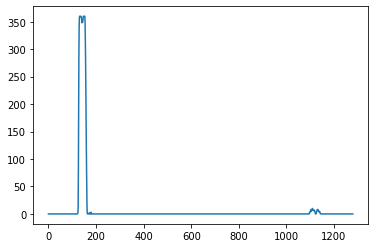

In [52]:
histogram = hist(warped_img)
plt.plot(histogram)
plt.savefig('output_images/histogram.jpg')

## 2. Find lanes with sliding window

In [44]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = hist(binary_warped)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int64(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
   
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int64(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

def second_ord_poly(line, val):
    a = line[0]
    b = line[1]
    c = line[2]
    formula = (a*val**2)+(b*val)+c

    return formula


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
     
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = second_ord_poly(left_fit, ploty)
        right_fitx = second_ord_poly(right_fit, ploty)
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    return out_img, [left_fitx, ploty], [right_fitx, ploty], left_fit, right_fit

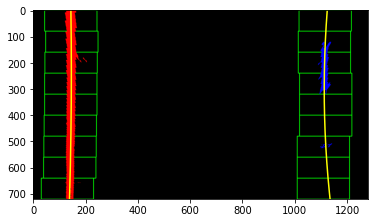

In [53]:
windows_with_lane_fit_img, left_plot, right_plot, left_fit, right_fit = fit_polynomial(warped_img)
# Plots the left and right polynomials on the lane lines
plt.plot(left_plot[0], left_plot[1], color='yellow')
plt.plot(right_plot[0], right_plot[1], color='yellow')
plt.imshow(windows_with_lane_fit_img)
plt.savefig('output_images/color_fit_lines.jpg')

# Determine curvature

In [134]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
def measure_curvature_real(left_plot, left_fit, right_fit):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(left_plot[1])
    
    y = y_eval*ym_per_pix
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit[0]*y + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    return left_curverad, right_curverad

In [135]:
# # Calculate the radius of curvature in meters for both lane lines
# left_curverad, right_curverad = measure_curvature_real()
# avg_rad = round(np.mean([left_curverad, right_curverad]),0)

In [136]:
def print_curv(image):
    middle_of_image = image.shape[1] / 2
    car_position = middle_of_image * xm_per_pix
    print(car_position)
    left_line_base = second_ord_poly(left_fit, image.shape[0] * ym_per_pix)
    right_line_base = second_ord_poly(right_fit, image.shape[0] * ym_per_pix)

    lane_mid = (left_line_base + right_line_base) / 2

    # Calculate distance from center and list differently based on left or right
    dist_from_center = lane_mid - car_position
    if dist_from_center >= 0:
        center_text = '{} meters left of center'.format(round(dist_from_center,2))
    else:
        center_text = '{} meters right of center'.format(round(-dist_from_center,2))

    rad_text = 'Radius of Curvature = {} m'.format(avg_rad)

    # List car's position in relation to middle on the image and radius of curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(image, center_text, (10,50), font, 1,(255,255,255),2)
    cv2.putText(image, rad_text, (10,100), font, 1,(255,255,255),2)


# Warp detected lane boundaries back to image

In [137]:
def warp_back(warped, orig, M, left_plot, right_plot):
    M_inv = np.linalg.inv(M)

    warped_zero = np.zeros_like(warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))

    pts_left = np.array([np.transpose(np.vstack(left_plot))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack(np.vstack(right_plot))))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0, 255, 0))

    back_warped = cv2.warpPerspective(color_warped, M_inv, (orig.shape[1], orig.shape[0]))
    result = cv2.addWeighted(orig, 1, back_warped, 0.3, 0)
    
    return result

# result = warp_back()
# plt.imshow(result)

# Create pipeline

Transformation matrix:  [[-7.86591124e-01 -1.46813031e+00  1.11958924e+03]
 [-2.27373675e-16 -2.32776204e+00  1.11718130e+03]
 [-7.36979174e-19 -2.38432483e-03  1.00000000e+00]]


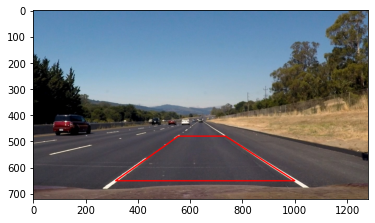

In [138]:
file, transformation_img = images[1]
M, copy = get_transformation_matrix(transformation_img)
plt.imshow(copy)
print("Transformation matrix: ", M)

def process_image(img):
    global left_line
    global right_line

    undistorted = undistort_img(img)
    thresholded = thresholded_image(undistorted)
    roi = region_of_interest(thresholded)
    warped = pers_transform(roi, M)
    img_with_lane_fit_img, left_plot, right_plot, left_fit, right_fit = fit_polynomial(warped)
    result = warp_back(warped, img, M, left_plot, right_plot)

    left_curv, right_curv = measure_curvature_real(left_plot, left_fit, right_fit)
    avg_curv = round(np.mean([left_curv, right_curv]),0)
    curv_text = 'Radius of Curvature = {} m'.format(avg_curv)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, curv_text, (10,100), font, 1,(255,255,255),2)

    return result

# Video processing

In [139]:
from moviepy.editor import VideoFileClip

input_file = 'project_video.mp4'
result_file = 'reg_vid.mp4'
    
clip = VideoFileClip(input_file)
processed_clip = clip.fl_image(process_image)
processed_clip.write_videofile(result_file, audio=False)

t:   0%|          | 2/1260 [00:00<01:03, 19.78it/s, now=None]

Moviepy - Building video reg_vid.mp4.
Moviepy - Writing video reg_vid.mp4



Moviepy - Done !
Moviepy - video ready reg_vid.mp4


## Debug

In [101]:
def load_test_img():
    img_glob = glob.glob('test_images/*.jpg')

    images = []
    # Step through the list and search for chessboard corners
    for fname in img_glob:
        img = cv2.imread(fname)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        images.append((fname,img))
        
    return images

images = load_test_img()

def browse_undistorted(images=images):
    n = len(images)
    def view_image(i):
        file, img = images[i]
        undistorted = undistort_img(img)
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title(file, fontsize=30)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=30)
    interact(view_image, i=(0,n-1))
    
%matplotlib inline
browse_undistorted()

interactive(children=(IntSlider(value=3, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

In [99]:
def browse_images():
    n = len(images)
    def view_image(i):
        file, image = images[i]
        process_image(image)
    interact(view_image, i=(0,n-1))
    
%matplotlib inline
browse_images()

interactive(children=(IntSlider(value=3, description='i', max=7), Output()), _dom_classes=('widget-interact',)…

error reading video


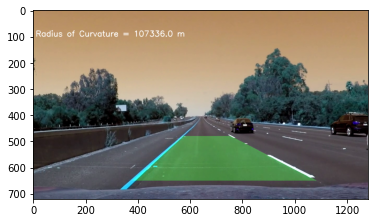

In [100]:
vidcap = cv2.VideoCapture(input_file)

success = True

while success:
    success, test_image = vidcap.read()

    if success:
        res = process_image(test_image)
        plt.imshow(res)

    else:
        print('error reading video')
        break